### Overview

In the realm of natural language processing, advancements in large language models (LLMs) have reached remarkable heights, enabling the generation of text that closely mirrors human-written content. In October 2023, a notable competition surfaced on [Kaggle](https://www.kaggle.com/competitions/llm-detect-ai-generated-text), centering around the intricacies of natural language processing. This competition seeks to foster open research and transparency in AI detection techniques applicable to real-world scenarios.

The challenge at hand involves developing a robust machine learning model capable of accurately discerning whether an essay was penned by a student or generated by an LLM. The competition dataset is a diverse compilation of student-written essays alongside essays produced by various LLMs. However, upon preliminary analysis, it is evident that the training set contains a limited number of AI-generated texts. To address this limitation, I will supplement the dataset with additional text sources that are comparable to LLM-generated content.

In this notebook, I aim to delve into the intricacies of the competition, exploring the dataset nuances and discussing the unique characteristics of LLM-generated texts. By leveraging alternative datasets, I seek to enhance the model's performance and contribute valuable insights to the ongoing discourse on AI detection techniques.

### Environment

First I set up the runtime environment based on [*Spark NLP - Quick Start for Google Colab*](https://github.com/JohnSnowLabs/spark-nlp/blob/master/examples/python/quick_start_google_colab.ipynb) by John Snow LABS. Spark NLP is an open-source library built on top of Apache Spark and Spark ML. Itprovides simple, performant & accurate NLP annotations for machine learning pipelines that can scale easily in a distributed environment.

In [1]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2024-02-07 09:22:02--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2024-02-07 09:22:02--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1191 (1.2K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.16K  --.-KB/s    in 0s      

2024-02-07 09:22:02 (81.9 MB/s) - written to stdout [1191/1191]

Installing

In [2]:
import sparknlp
spark = sparknlp.start()

print("Spark NLP version: {}".format(sparknlp.version()))
print("Apache Spark version: {}".format(spark.version))

Spark NLP version: 5.2.3
Apache Spark version: 3.2.3


And other libraries.

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import nltk
nltk.download("stopwords")
nltk.download("punkt")
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

import pyspark.sql.functions as F
from pyspark.sql.functions import col, isnan, explode, desc, rank, lower, regexp_replace, udf, length, mean, lit, expr, when
from pyspark.sql import Window
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, HashingTF, IDF, StringIndexer
from pyspark.ml import Pipeline
from sparknlp.annotator import DocumentAssembler, T5Transformer, UniversalSentenceEncoder, ClassifierDLApproach
from sparknlp.base import LightPipeline
from sparknlp.pretrained import PretrainedPipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.clustering import LDA

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data

#### Original training set

In [ ]:
path = "./data/llm-detect-ai-generated-text/train_essays.csv"
train_essays = pd.read_csv(path)

In [ ]:
train_essays = spark.createDataFrame(train_essays)

Original training set from competition (*train_essays*) consists of following columns:
- **id** - a unique identifier for each essay,
- **prompt_id** - identifies the prompt the essay was written in response to,
- **text** - the essay text itself,
- **generated** - this field is the target, it informs whether the essay was written by a student (`0`) or generated by an LLM (`1`).

In [ ]:
train_essays.show(5)

+--------+---------+--------------------+---------+
|      id|prompt_id|                text|generated|
+--------+---------+--------------------+---------+
|0059830c|        0|Cars. Cars have b...|        0|
|005db917|        0|Transportation is...|        0|
|008f63e3|        0|"America's love a...|        0|
|00940276|        0|How often do you ...|        0|
|00c39458|        0|Cars are a wonder...|        0|
+--------+---------+--------------------+---------+
only showing top 5 rows



There are also train prompts in other file, which consists of following columns:
- **prompt_id** - a unique identifier for each prompt,
- **prompt_name** - the title of the prompt,
- **instructions** - the instructions given to students,
- **source_text** - the text of the article(s) the essays were written in response to, in Markdown format. Significant paragraphs are enumerated by a numeral preceding the paragraph on the same line, as in `0 Paragraph one.\n\n1 Paragraph two.`. Essays sometimes refer to a paragraph by its numeral. Each article is preceded with its title in a heading, like `# Title`. When an author is indicated, their name will be given in the title after `by`. Not all articles have authors indicated. An article may have subheadings indicated like `## Subheading`.

In [ ]:
path = "./data/llm-detect-ai-generated-text/train_prompts.csv"
train_prompts = pd.read_csv(path)
train_prompts = spark.createDataFrame(train_prompts)
train_prompts.show()

+---------+--------------------+--------------------+--------------------+
|prompt_id|         prompt_name|        instructions|         source_text|
+---------+--------------------+--------------------+--------------------+
|        0|     Car-free cities|Write an explanat...|# In German Subur...|
|        1|Does the electora...|Write a letter to...|# What Is the Ele...|
+---------+--------------------+--------------------+--------------------+



For now let's focus on *train_essays* and check some simple statistics.

In [ ]:
print(f"Number of essays in train set: {train_essays.count()}")

Number of essays in train set: 1378


In [ ]:
num_generated = train_essays.groupBy("generated").count()
print("Number of student and LLM generated essays:")
num_generated.show()

Number of student and LLM generated essays:
+---------+-----+
|generated|count|
+---------+-----+
|        0| 1375|
|        1|    3|
+---------+-----+



As mentioned earlier, the number of essays generated by LLMs in the training set is quite limited. The entire dataset consists of 1378 records, with only three of them being AI-generated essays. This accounts for a mere 0.002 percent of all records, highlighting a substantial imbalance in the dataset. Fortunately, the community has actively addressed this issue by taking matters into their own hands to supplement and enhance the training set, aiming to acquire data that would facilitate more effective model training.

A noteworthy example of such a dataset is the new [**V2 release of the DAIGT train dataset**](https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset). This updated version incorporates new prompts and incorporates the use of novel language models. The collective efforts of the community in augmenting the dataset underscore the commitment to improving the efficacy of model training. This notebook will explore these dataset dynamics and delve into the enhancements introduced by the community to create a more robust and representative training set for tackling the challenge posed by the Kaggle competition.

#### DAIGT v2

In [4]:
path = "./data/daigt_v2/train_v2_drcat_02.csv"
data_pd = pd.read_csv(path)

In [5]:
data = spark.createDataFrame(data_pd)
data.show(5)

+--------------------+-----+------------------+---------------+-------------+
|                text|label|       prompt_name|         source|RDizzl3_seven|
+--------------------+-----+------------------+---------------+-------------+
|Phones\r\n\r\nMod...|    0|Phones and driving|persuade_corpus|        false|
|This essay will e...|    0|Phones and driving|persuade_corpus|        false|
|Driving while the...|    0|Phones and driving|persuade_corpus|        false|
|Phones & Driving\...|    0|Phones and driving|persuade_corpus|        false|
|Cell Phone Operat...|    0|Phones and driving|persuade_corpus|        false|
+--------------------+-----+------------------+---------------+-------------+
only showing top 5 rows



In [ ]:
data.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: long (nullable = true)
 |-- prompt_name: string (nullable = true)
 |-- source: string (nullable = true)
 |-- RDizzl3_seven: boolean (nullable = true)



In [ ]:
def check_nans(data, columns):
    nan_columns = []
    for col_name in columns:
        nan_count = data.where(col(col_name).isNull() | isnan(col(col_name))).count()
        if nan_count > 0:
            nan_columns.append(col_name)
            print(f"NaN values in column {col_name}: {nan_count}")
    if not nan_columns:
        print("No NaN values found in any column")

columns = ["text", "label", "prompt_name", "source"]
check_nans(data, columns)

No NaN values found in any column


In [ ]:
print(f"Number of essays in dataset: {data.count()}")

Number of essays in dataset: 44868


In [ ]:
num_generated = data.groupBy("label").count()
print("Number of student and LLM generated essays:")
num_generated.show()

Number of student and LLM generated essays:
+-----+-----+
|label|count|
+-----+-----+
|    0|27371|
|    1|17497|
+-----+-----+



In [ ]:
num_prompts = data.groupBy("prompt_name").count()
print("Prompts used:")
num_prompts.show()

Prompts used:
+--------------------+-----+
|         prompt_name|count|
+--------------------+-----+
|  Phones and driving| 1583|
|Does the electora...| 4434|
|"A Cowboy Who Rod...| 1896|
|     Exploring Venus| 2176|
|Mandatory extracu...| 3077|
|     Driverless cars| 2250|
|     Car-free cities| 4717|
|   Distance learning| 5554|
|Cell phones at sc...| 2119|
|Grades for extrac...| 2116|
|     Summer projects| 2701|
|   Community service| 2092|
|    The Face on Mars| 1893|
|Facial action cod...| 3084|
|Seeking multiple ...| 5176|
+--------------------+-----+



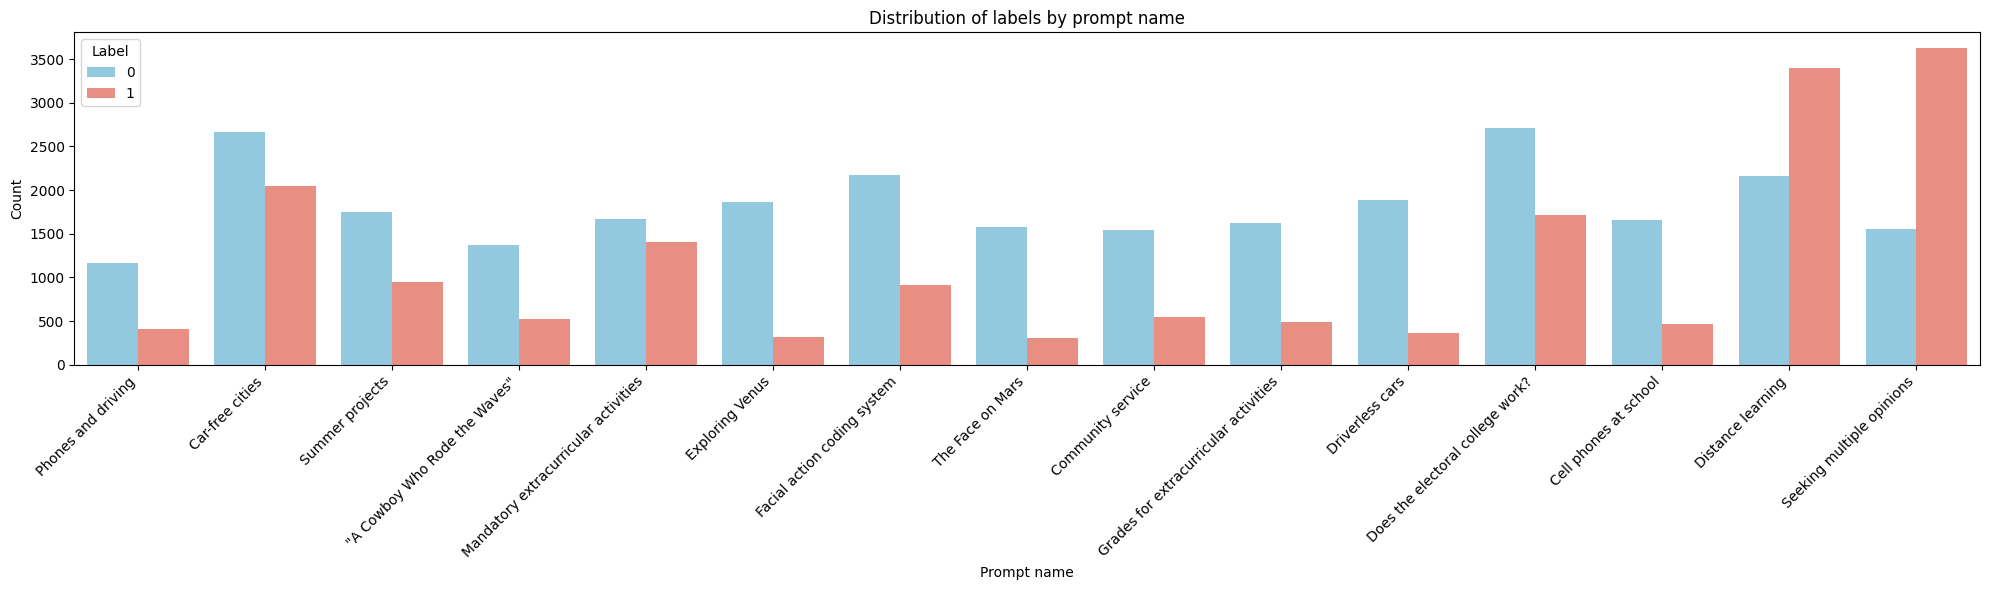

In [ ]:
plt.figure(figsize = (20, 6))
sns.countplot(data = data_pd, x = "prompt_name", hue = "label", palette = {0: "skyblue", 1: "salmon"})
plt.title("Distribution of labels by prompt name")
plt.xlabel("Prompt name")
plt.ylabel("Count")
plt.xticks(rotation = 45, ha = "right")
plt.legend(title = "Label", labels = ["0", "1"])
plt.tight_layout()
plt.show()

Dataset was improved using following sources:
- text generated with ChatGPT by MOTH (https://www.kaggle.com/datasets/alejopaullier/daigt-external-dataset),
- persuade corpus contributed by Nicholas Broad (https://www.kaggle.com/datasets/nbroad/persaude-corpus-2/),
- text generated with Llama-70b and Falcon180b by Nicholas Broad (https://www.kaggle.com/datasets/nbroad/daigt-data-llama-70b-and-falcon180b),
- text generated with ChatGPT and GPT4 by Radek (https://www.kaggle.com/datasets/radek1/llm-generated-essays),
- 2000 Claude essays generated by @darraghdog (https://www.kaggle.com/datasets/darraghdog/hello-claude-1000-essays-from-anthropic),
- LLM-generated essay using PaLM from Google Gen-AI by @kingki19 (https://www.kaggle.com/datasets/kingki19/llm-generated-essay-using-palm-from-google-gen-ai),
- official train essays,
- essays generated by Darek Kłeczek with various LLMs.

In [ ]:
num_sources = data.groupBy("source").count()
print("Sources:")
num_sources.show()

Sources:
+--------------------+-----+
|              source|count|
+--------------------+-----+
|     persuade_corpus|25996|
|           radekgpt4|  200|
|mistralai/Mistral...|  400|
|NousResearch/Llam...|  400|
|   darragh_claude_v7| 1000|
|           radek_500|  500|
|       chat_gpt_moth| 2421|
|mistral7binstruct_v1| 2421|
|mistral7binstruct_v2| 2421|
|        train_essays| 1378|
|       kingki19_palm| 1384|
|      cohere-command|  350|
|        llama_70b_v1| 1172|
|    palm-text-bison1|  349|
|   darragh_claude_v6| 1000|
|         llama2_chat| 2421|
|      falcon_180b_v1| 1055|
+--------------------+-----+



### Essay texts analysis

First of all let's check if there are any duplicated essays.

In [ ]:
duplicates = data.groupBy("text").count().filter(col("count") > 1)
duplicates.show()

+----+-----+
|text|count|
+----+-----+
+----+-----+



Now I do a quick tokenization, and then I get individual words by exploding *words* column, so we can check **top frequent words** for each label.

In [ ]:
tokenizer = Tokenizer(inputCol = "text", outputCol = "words")
tokenized_data = tokenizer.transform(data)

In [ ]:
exploded_data = tokenized_data.select(col("label"), explode("words").alias("word"))
word_counts = exploded_data.groupBy("label", "word").count()
window_spec = Window.partitionBy("label").orderBy(desc("count"))
ranked_words = word_counts.withColumn("rank", rank().over(window_spec))
top_words = ranked_words.filter(col("rank") <= 5)
#top_words.show()

These words doesn't give much information so maybe let's do data cleaning first.

In [6]:
def clean_text(data):
    # Lowercase
    data = data.withColumn("cleaned_text", lower(col("text")))
    # Numbers
    data = data.withColumn("cleaned_text", regexp_replace(col("text"), "\\d+", " "))
    # Punctuation
    data = data.withColumn("cleaned_text", regexp_replace(col("cleaned_text"), "[^a-zA-Z\\s']", " "))
    # Multiple whitespaces
    data = data.withColumn("cleaned_text", regexp_replace(col("cleaned_text"), "\\s+", " "))

    return data

# Tokenization
tokenizer = Tokenizer(inputCol = "cleaned_text", outputCol = "words")

# Stopwords
additional_stopwords = [] # Optionally
all_stopwords = StopWordsRemover().getStopWords() + additional_stopwords

stop_words_remover = StopWordsRemover(
    inputCol = "words", outputCol = "filtered_words",
    stopWords = all_stopwords
)

In [7]:
cleaned_data = clean_text(data)
cleaned_data = tokenizer.transform(cleaned_data)
cleaned_data = stop_words_remover.transform(cleaned_data)

Filtering empty tokens after data cleaning using UDF. A User-Defined Function (UDF) is a feature in Spark that allows to define functions and use them in SQL expressions.

In [8]:
def remove_empty_tokens(words):
    return [word for word in words if len(word) > 0]

remove_empty_tokens_udf = spark.udf.register(
    "remove_empty_tokens", remove_empty_tokens, ArrayType(StringType())
)
cleaned_data = cleaned_data.withColumn(
    "filtered_words", remove_empty_tokens_udf(col("filtered_words"))
)

In [9]:
cleaned_data.show(5)

+--------------------+-----+------------------+---------------+-------------+--------------------+--------------------+--------------------+
|                text|label|       prompt_name|         source|RDizzl3_seven|        cleaned_text|               words|      filtered_words|
+--------------------+-----+------------------+---------------+-------------+--------------------+--------------------+--------------------+
|Phones\r\n\r\nMod...|    0|Phones and driving|persuade_corpus|        false|Phones Modern hum...|[phones, modern, ...|[phones, modern, ...|
|This essay will e...|    0|Phones and driving|persuade_corpus|        false|This essay will e...|[this, essay, wil...|[essay, explain, ...|
|Driving while the...|    0|Phones and driving|persuade_corpus|        false|Driving while the...|[driving, while, ...|[driving, use, ce...|
|Phones & Driving\...|    0|Phones and driving|persuade_corpus|        false|Phones Driving Dr...|[phones, driving,...|[phones, driving,...|
|Cell Phone O

In [ ]:
cleaned_data_label_0 = cleaned_data.filter(col("label") == 0)
exploded_data = cleaned_data_label_0.select(
    col("label"), explode("filtered_words").alias("word")
)
word_counts = exploded_data.groupBy("label", "word").count()
window_spec = Window.partitionBy("label").orderBy(desc("count"))
ranked_words = word_counts.withColumn("rank", rank().over(window_spec))
top_words = ranked_words.filter(col("rank") <= 10)

print("Top words for label 0:")
top_words.show()

Top words for label 0:
+-----+--------+-----+----+
|label|    word|count|rank|
+-----+--------+-----+----+
|    0|students|94886|   1|
|    0|  people|72426|   2|
|    0|  school|59071|   3|
|    0|     get|42205|   4|
|    0|    like|37917|   5|
|    0|     car|37533|   6|
|    0|     one|37245|   7|
|    0|    help|36881|   8|
|    0|    time|36661|   9|
|    0|    also|36606|  10|
+-----+--------+-----+----+



In [ ]:
cleaned_data_label_1 = cleaned_data.filter(col("label") == 1)
exploded_data = cleaned_data_label_1.select(
    col("label"), explode("filtered_words").alias("word")
)
word_counts = exploded_data.groupBy("label", "word").count()
window_spec = Window.partitionBy("label").orderBy(desc("count"))
ranked_words = word_counts.withColumn("rank", rank().over(window_spec))
top_words = ranked_words.filter(col("rank") <= 10)

print("Top words for label 1:")
top_words.show()

Top words for label 1:
+-----+---------+-----+----+
|label|     word|count|rank|
+-----+---------+-----+----+
|    1| students|39027|   1|
|    1|     like|25588|   2|
|    1|     also|23740|   3|
|    1|   people|22475|   4|
|    1|     help|21912|   5|
|    1|      car|21173|   6|
|    1|      may|19863|   7|
|    1|   school|19496|   8|
|    1|electoral|18685|   9|
|    1|     time|18407|  10|
+-----+---------+-----+----+



I also check some basic statistics for number of characters - first of all for all essays.

In [ ]:
min_chars = cleaned_data.selectExpr("min(length(text))").collect()[0][0]
max_chars = cleaned_data.selectExpr("max(length(text))").collect()[0][0]
mean_chars = cleaned_data.selectExpr("avg(length(text))").collect()[0][0]

print(f"Minimum number of characters: {min_chars}")
print(f"Maximum number of characters: {max_chars}")
print(f"Mean number of characters: {round(mean_chars, 2)}")

Minimum number of characters: 48
Maximum number of characters: 18326
Mean number of characters: 2225.48


In [ ]:
#essays_with_max_chars = cleaned_data.filter(length("text") == max_chars).select("text").collect()
#essays_with_max_chars

After printing the longest essay we can see that most of the characters are non-breaking spaces, so this essay definitely doesn't have 18326 characters. Here's the fragment:

*or even get rid of most of the air polution not just in the united states or columbia or in germany...but get rid of air pollution in the whole intire world       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0       \xa0*

In order to obtain more precise and reliable statistics I will check it again using *cleaned_text* column, where I did some basic data cleaning with regex.

In [ ]:
min_chars = cleaned_data.selectExpr("min(length(cleaned_text))").collect()[0][0]
max_chars = cleaned_data.selectExpr("max(length(cleaned_text))").collect()[0][0]
mean_chars = cleaned_data.selectExpr("avg(length(cleaned_text))").collect()[0][0]

print(f"Minimum number of characters: {min_chars}")
print(f"Maximum number of characters: {max_chars}")
print(f"Mean number of characters: {round(mean_chars, 2)}")

Minimum number of characters: 47
Maximum number of characters: 9056
Mean number of characters: 2157.75


Checking the longest essay again.

In [ ]:
#essays_with_max_chars = cleaned_data\
#    .filter(length("cleaned_text") == max_chars)\
#    .select("cleaned_text").collect()
#essays_with_max_chars

And the shortest.

In [ ]:
essays_with_min_chars = cleaned_data\
    .filter(length("cleaned_text") == min_chars)\
    .select("cleaned_text").collect()
essays_with_min_chars

[Row(cleaned_text=' In recent years there has been a growing trend')]

It can be another mistake or maybe essay written by some really lazy student.

In [ ]:
shortest_essay_label = cleaned_data\
    .filter(length("cleaned_text") == min_chars)\
    .select("label")\
    .collect()[0][0]
shortest_essay_label

1

It has label 1 which means it's generated by LLM.

Now let's check statistics for each label separately.

In [ ]:
stats_label_0 = cleaned_data.filter(cleaned_data["label"] == 0)\
    .selectExpr("min(length(cleaned_text)) as min_chars",
                "max(length(cleaned_text)) as max_chars",
                "avg(length(cleaned_text)) as mean_chars")\
    .collect()[0]

stats_label_1 = cleaned_data.filter(cleaned_data["label"] == 1)\
    .selectExpr("min(length(cleaned_text)) as min_chars",
                "max(length(cleaned_text)) as max_chars",
                "avg(length(cleaned_text)) as mean_chars")\
    .collect()[0]

print("Statistics for label 0:")
print(f"Minimum number of characters: {stats_label_0['min_chars']}")
print(f"Maximum number of characters: {stats_label_0['max_chars']}")
print(f"Mean number of characters: {round(stats_label_0['mean_chars'], 2)}")
print()

print("Statistics for label 1:")
print(f"Minimum number of characters: {stats_label_1['min_chars']}")
print(f"Maximum number of characters: {stats_label_1['max_chars']}")
print(f"Mean number of characters: {round(stats_label_1['mean_chars'], 2)}")

Statistics for label 0:
Minimum number of characters: 686
Maximum number of characters: 9056
Mean number of characters: 2284.06

Statistics for label 1:
Minimum number of characters: 47
Maximum number of characters: 4936
Mean number of characters: 1960.16


Checking if this essay with number of characters equal to 47 is some exception or mistake, or we have more essays like this (for label 1).

In [ ]:
n = 300

essays_label_1_n = cleaned_data\
    .filter((cleaned_data["label"] == 1)\
            & (length("cleaned_text") <= n))

print(f"Number of essays with character counts less than or equal to {n} for label 1: {essays_label_1_n.count()}")

Number of essays with character counts less than or equal to 300 for label 1: 5


In [ ]:
essays_list = essays_label_1_n.select("cleaned_text").collect()
essays_list

[Row(cleaned_text='Passage Passage Passage Passage Passage Passage Passage Passage Passage Passage Passage Passage Passage Passage Passage Passage Passage Passage Passage Passage Passage Passage Passage Passage Passage '),
 Row(cleaned_text=' Dear Senator I am writing in support of keeping the Electoral College as the current method for electing the President of the United States Although there is ongoing debate about the effectiveness of the Electoral College and its potential drawbacks I believe that it'),
 Row(cleaned_text=' Limiting car usage is a concept that has gained significant attention in recent years due to its potential benefits Advocates of this movement argue that by reducing car usage society can experience numerous advantages such as improved air quality and reduced greenhouse gas emissions One example of'),
 Row(cleaned_text=' Car usage has long been a significant factor in American culture with cars being valued for their convenience and freedom to travel on long jou

We can see that there are more essays which look like cut in the middle or just mistaken f.e. this *Passage* one, which in original dataset looks like:

*Passage 1:*

*Passage 2:*

*Passage 3:*

*Passage 4:*

*Passage 5:*

*Passage 6:*

*Passage 7:*

*Passage 8:*

*Passage 9: (...)*

### Visualizations using pandas dataframe

In [ ]:
def clean_text_pandas(data):
    data["cleaned_text"] = data["text"].str.lower()
    data["cleaned_text"] = data["cleaned_text"].str.replace(r"\d+", " ")
    data["cleaned_text"] = data["cleaned_text"].str.replace("[^a-zA-Z\\s']", " ")
    data["cleaned_text"] = data["cleaned_text"].str.replace(r"\\s+", " ")

    return data

def tokenize_text(text):
    return word_tokenize(text)

stop_words = set(stopwords.words("english"))

def remove_short_tokens(words):
    return [word for word in words if len(word) > 3]

data_pd = clean_text_pandas(data_pd)
data_pd["words"] = data_pd["cleaned_text"].apply(tokenize_text)
data_pd["filtered_words"] = data_pd["words"].apply(lambda x: [word for word in x if word not in stop_words])
data_pd["filtered_words"] = data_pd["filtered_words"].apply(remove_short_tokens)

In [ ]:
def get_top_words_and_freqs(words, label, n = 15):
    word_freq = {}
    for word_list in words[data_pd["label"] == label]:
        for word in word_list:
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1

    sorted_word_freq = sorted(word_freq.items(), key = lambda x: x[1], reverse = True)

    top_words = [item[0] for item in sorted_word_freq[:n]]
    top_freqs = [item[1] for item in sorted_word_freq[:n]]

    return top_words, top_freqs

top_15_words_label_0, top_15_freqs_label_0 = get_top_words_and_freqs(
    data_pd["filtered_words"], label = 0
)
top_15_words_label_1, top_15_freqs_label_1 = get_top_words_and_freqs(
    data_pd["filtered_words"], label = 1
)

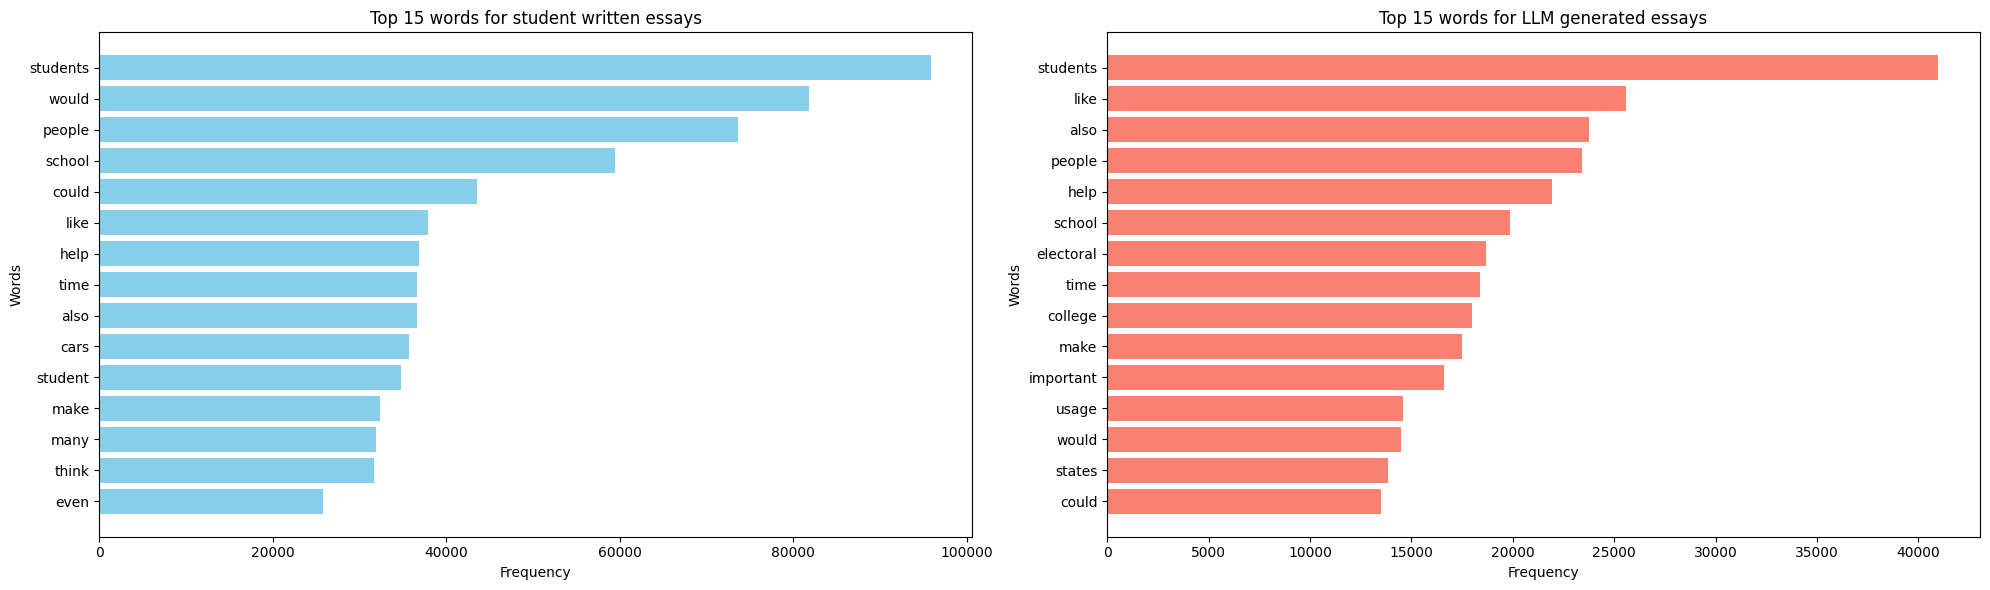

In [ ]:
plt.figure(figsize = (20, 6))

plt.subplot(1, 2, 1)
plt.barh(top_15_words_label_0, top_15_freqs_label_0, color = "skyblue")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 15 words for student written essays")
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh(top_15_words_label_1, top_15_freqs_label_1, color = "salmon")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 15 words for LLM generated essays")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

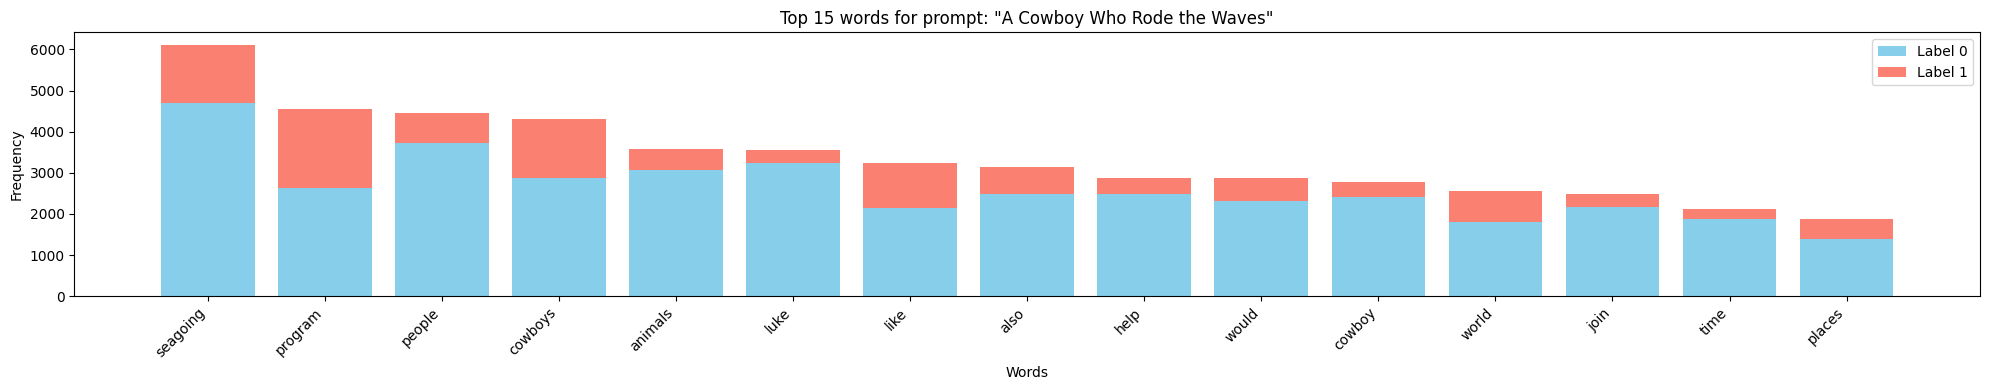

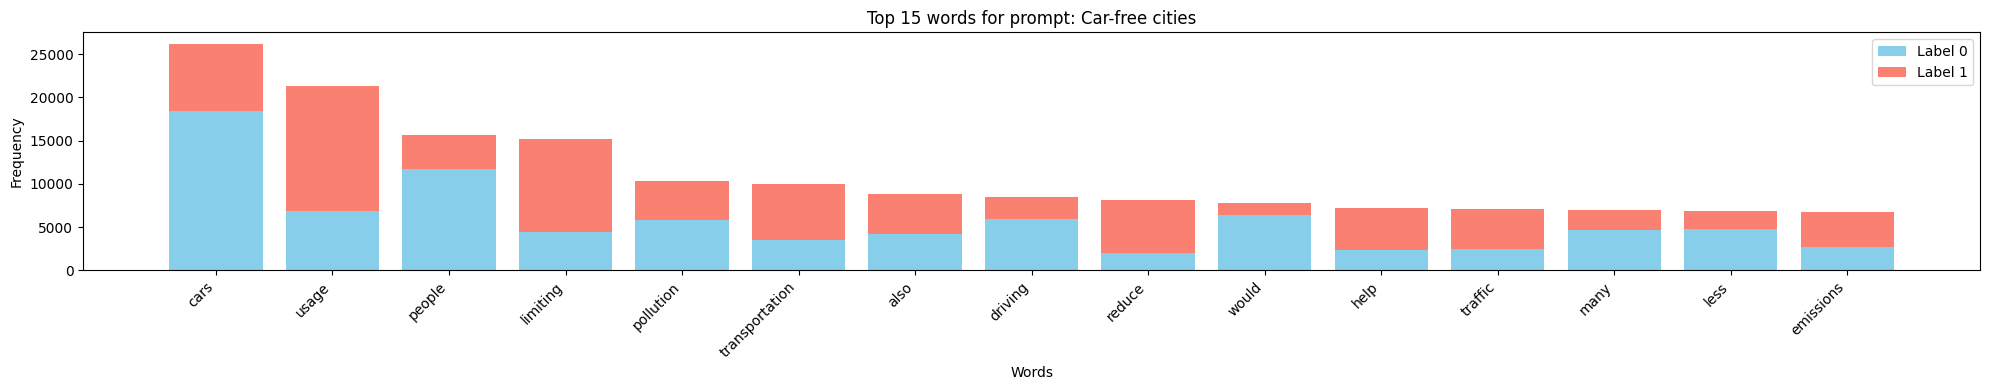

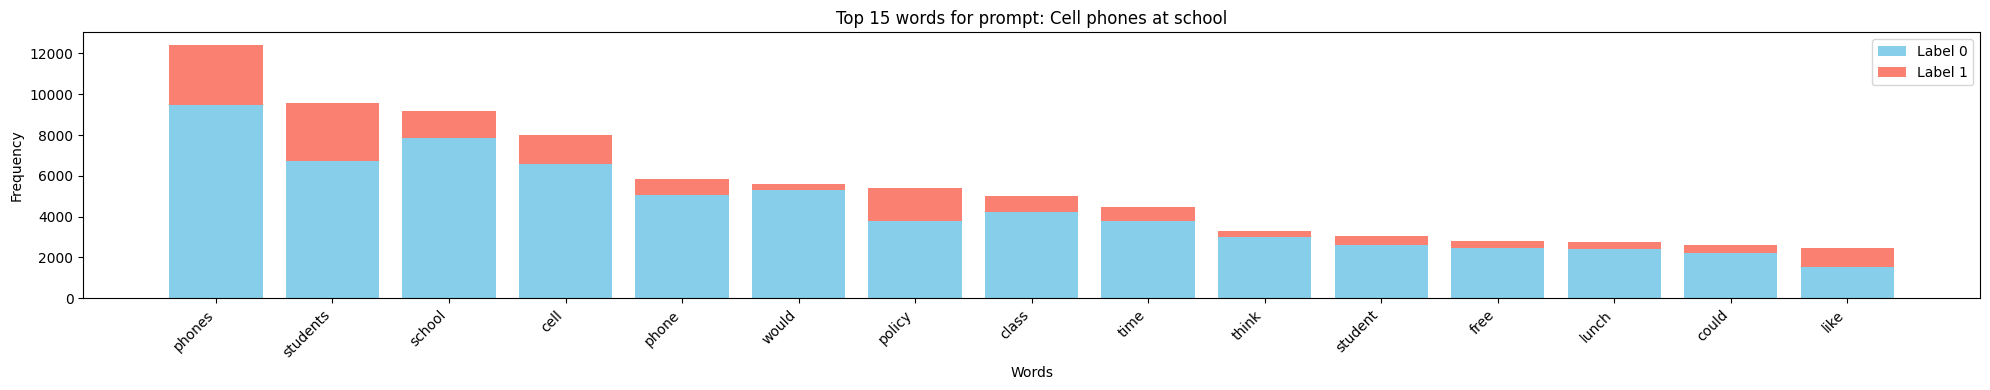

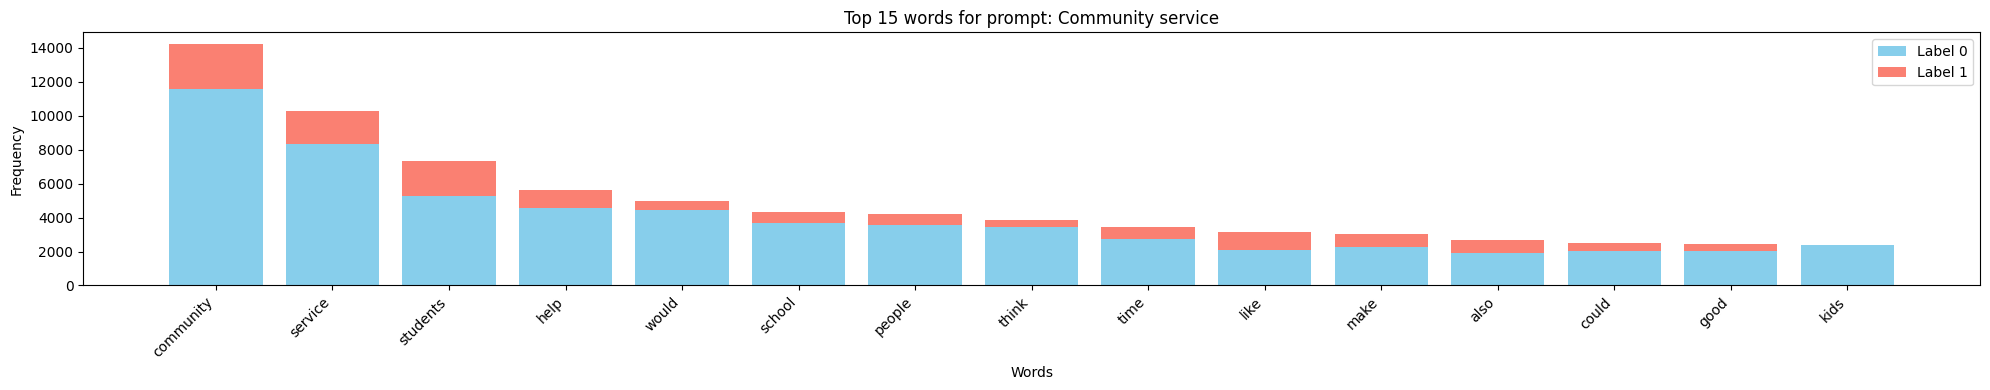

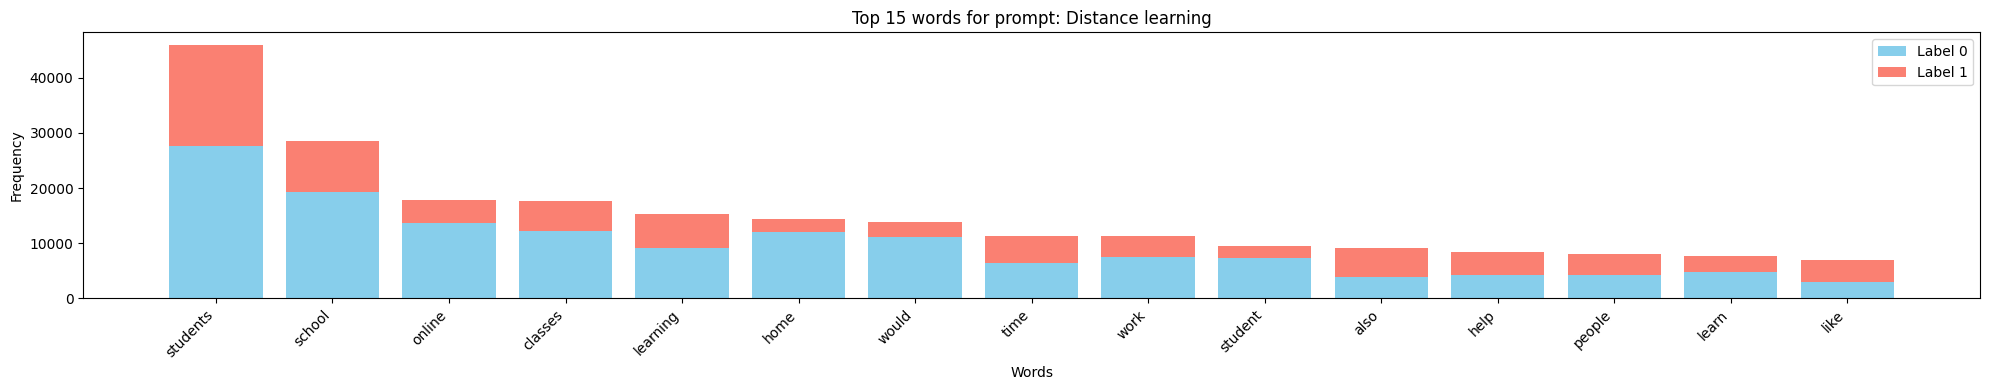

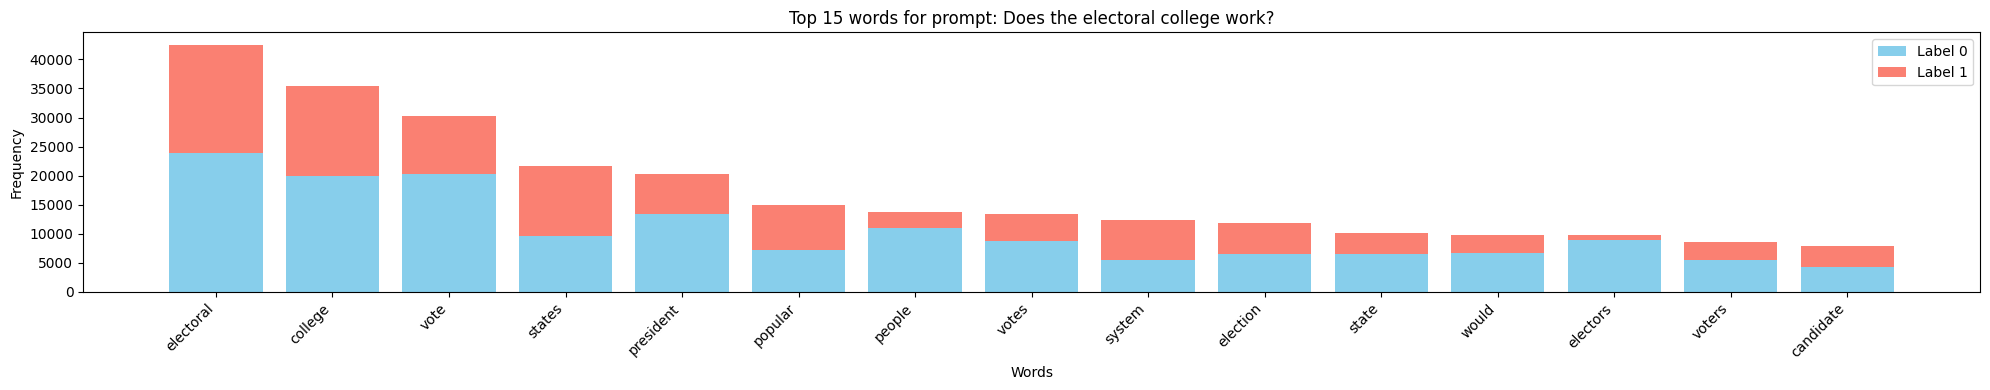

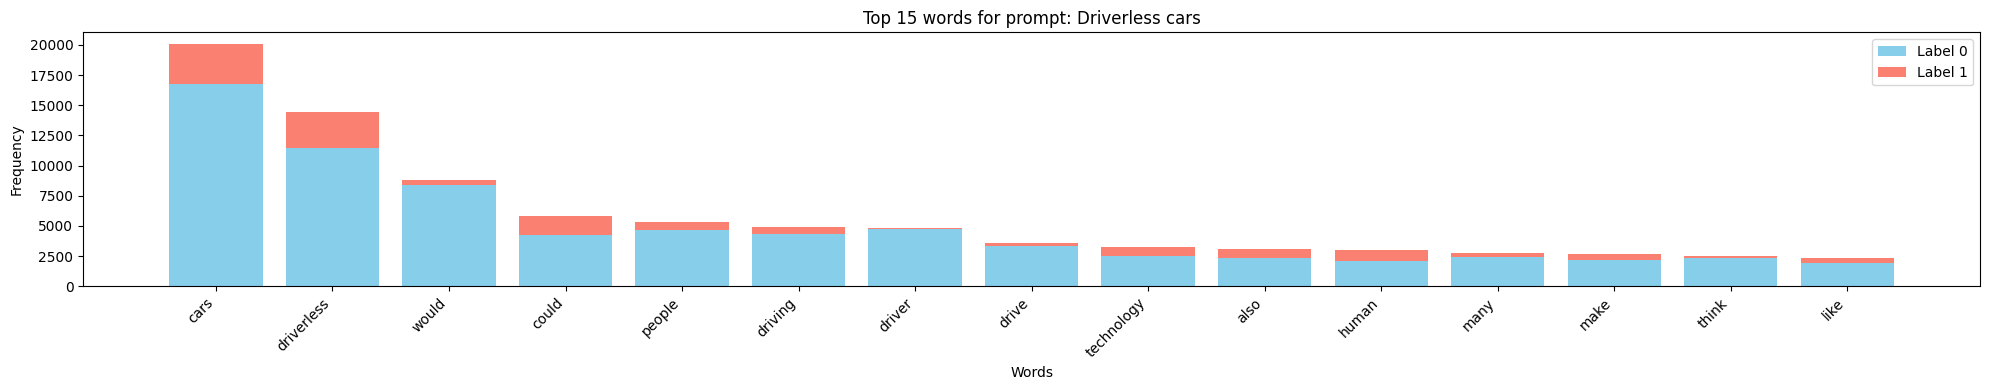

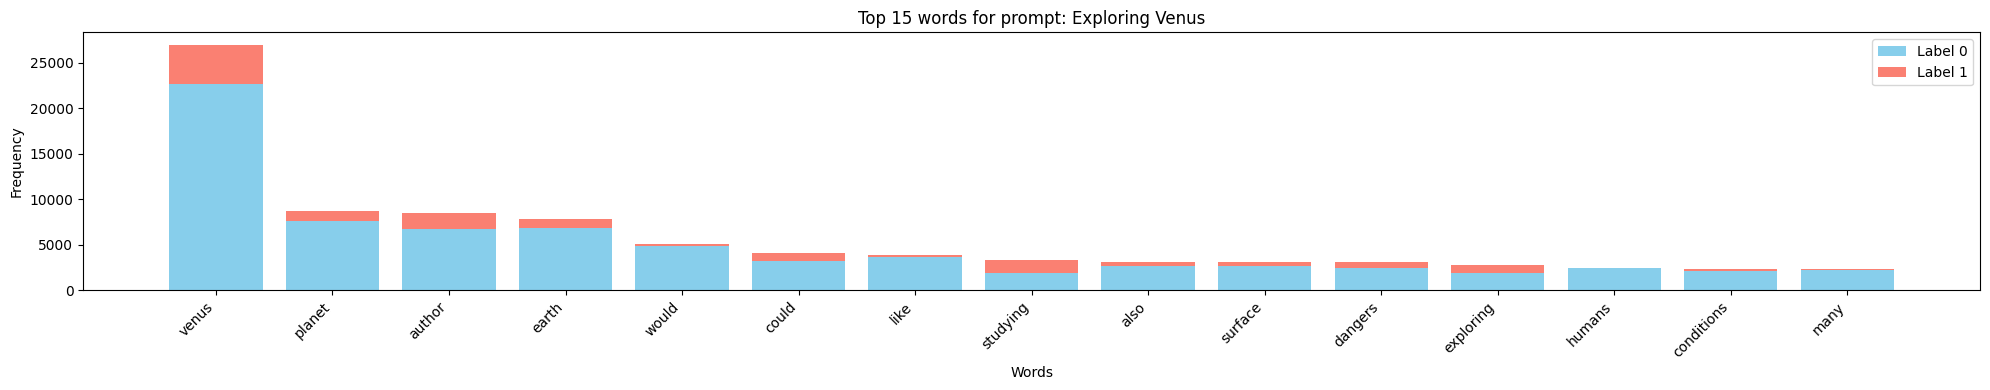

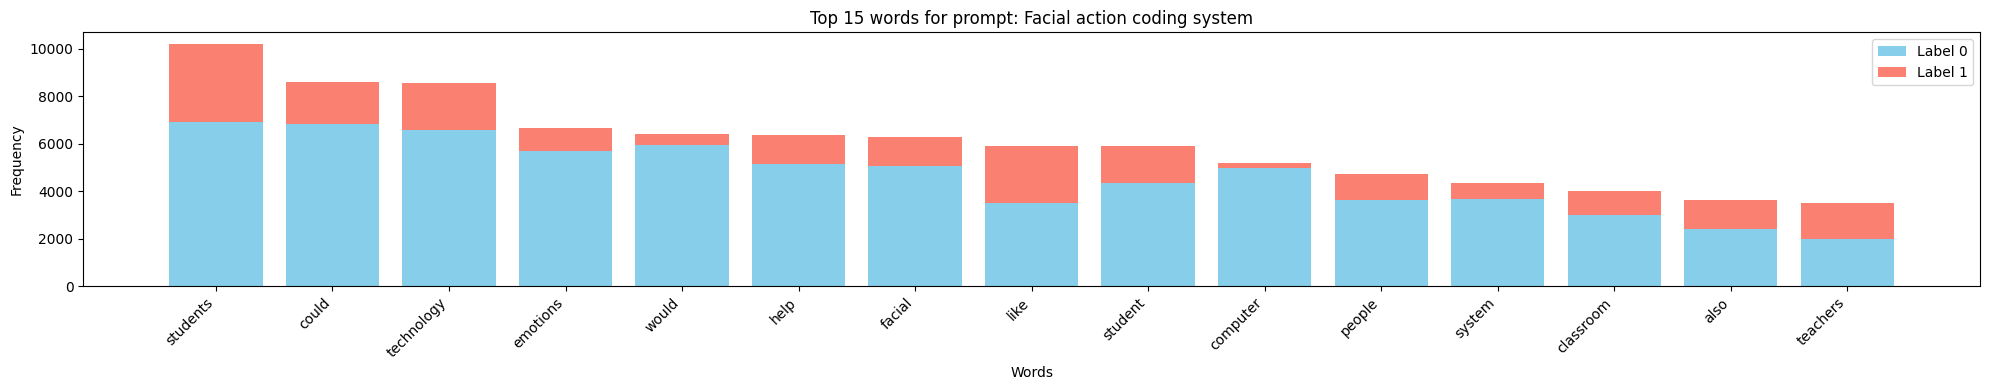

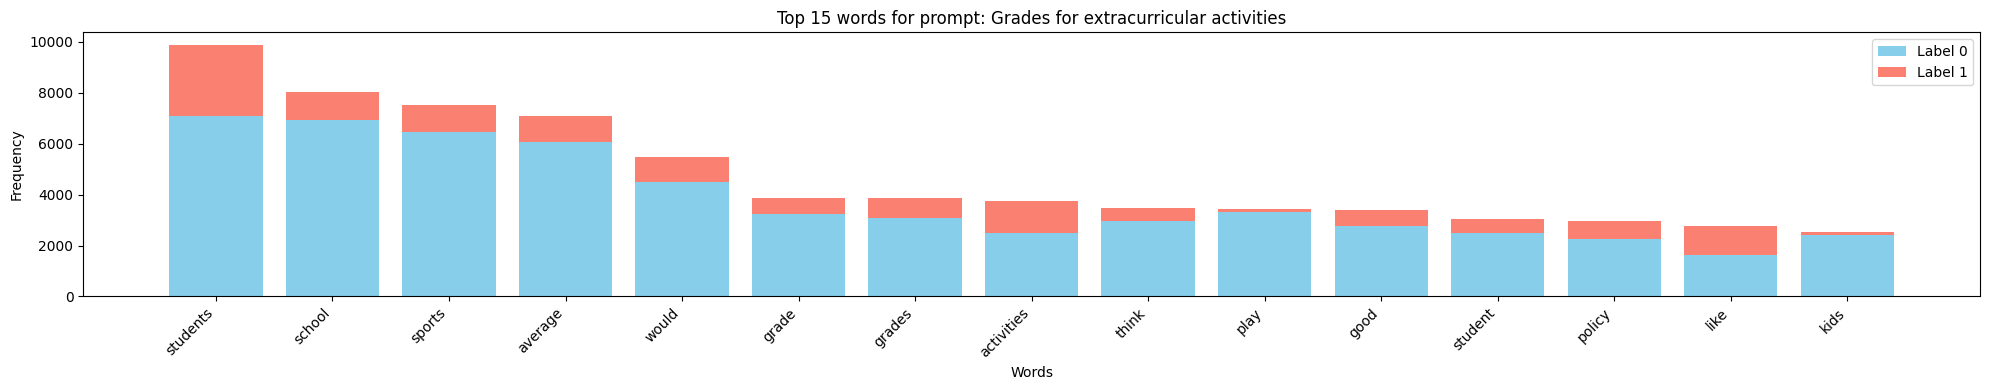

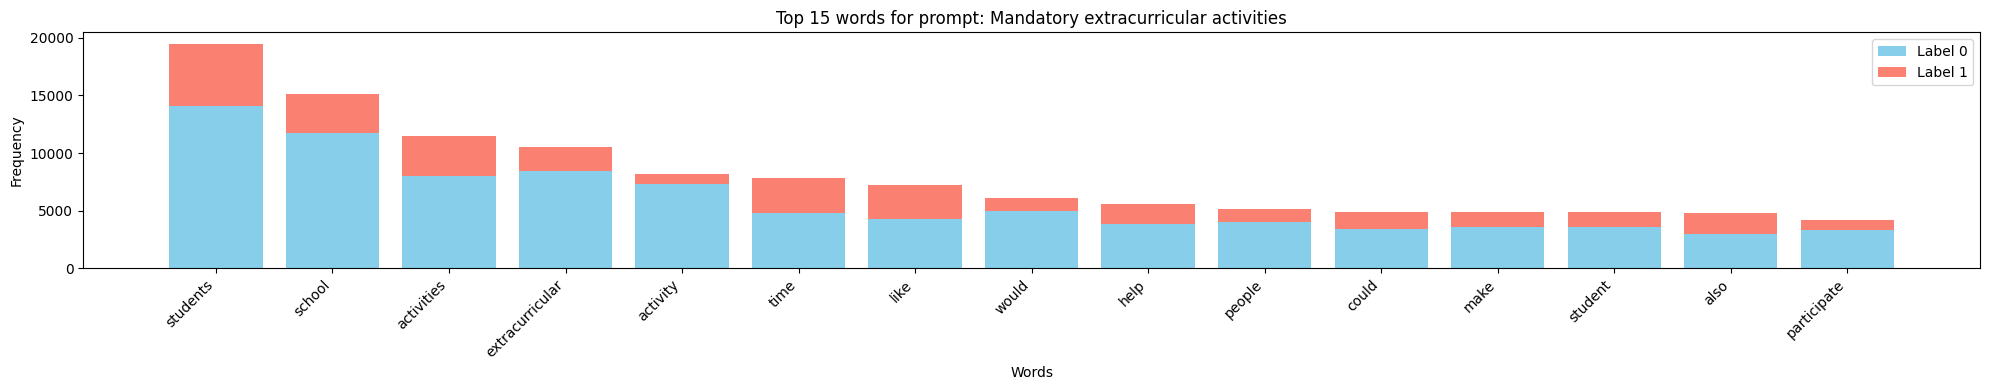

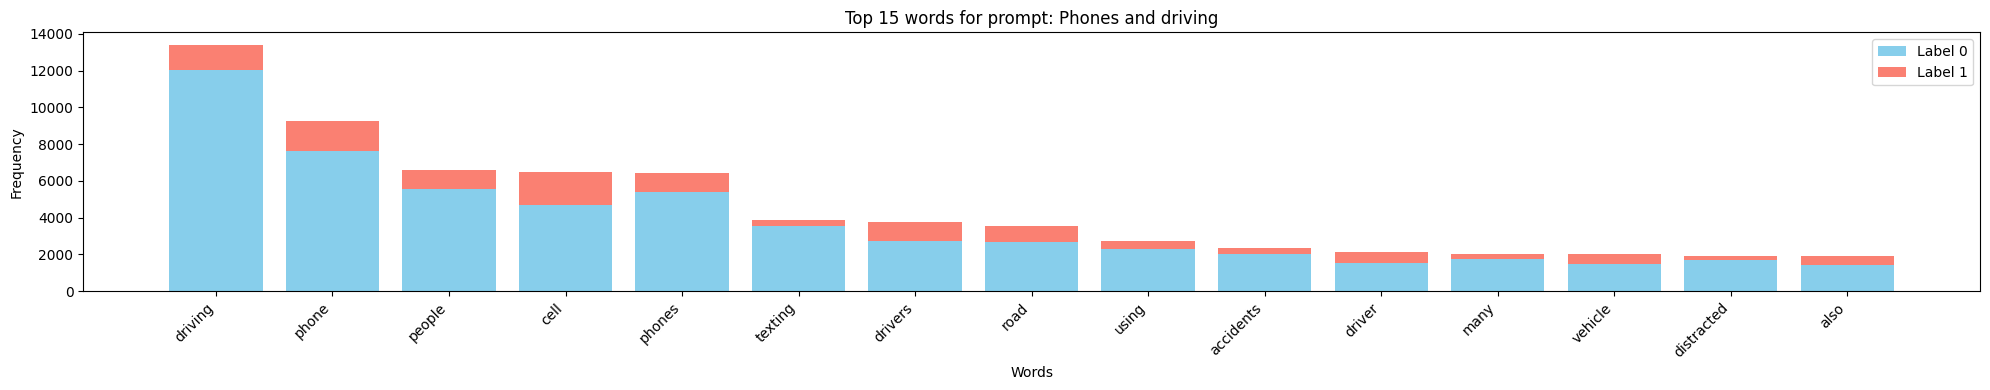

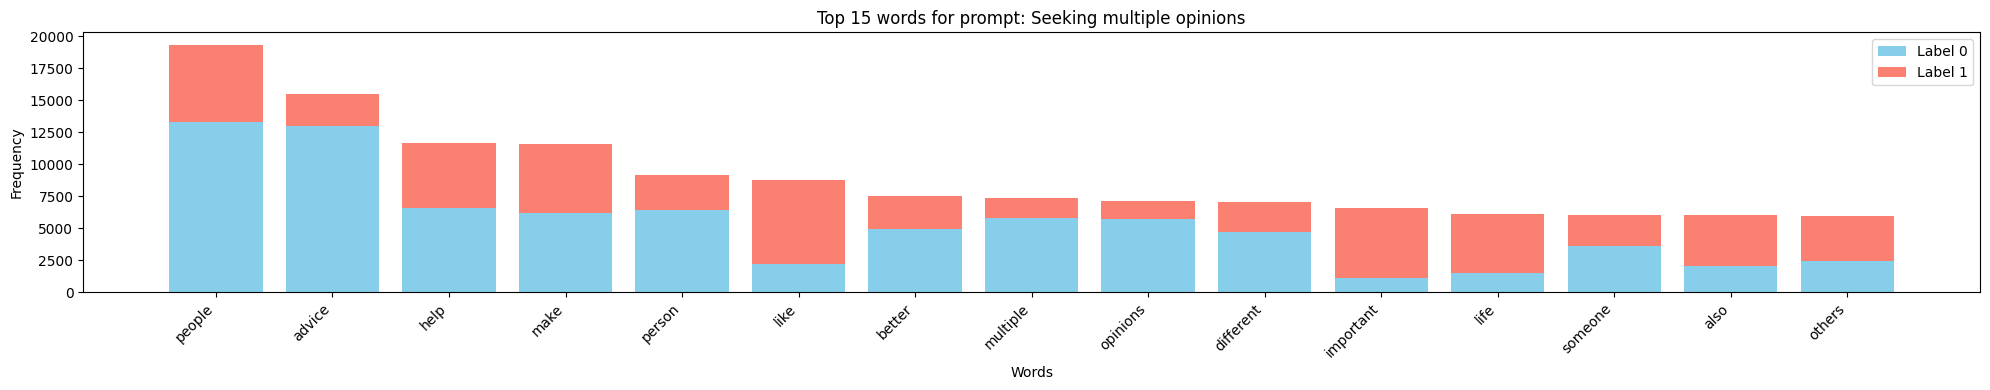

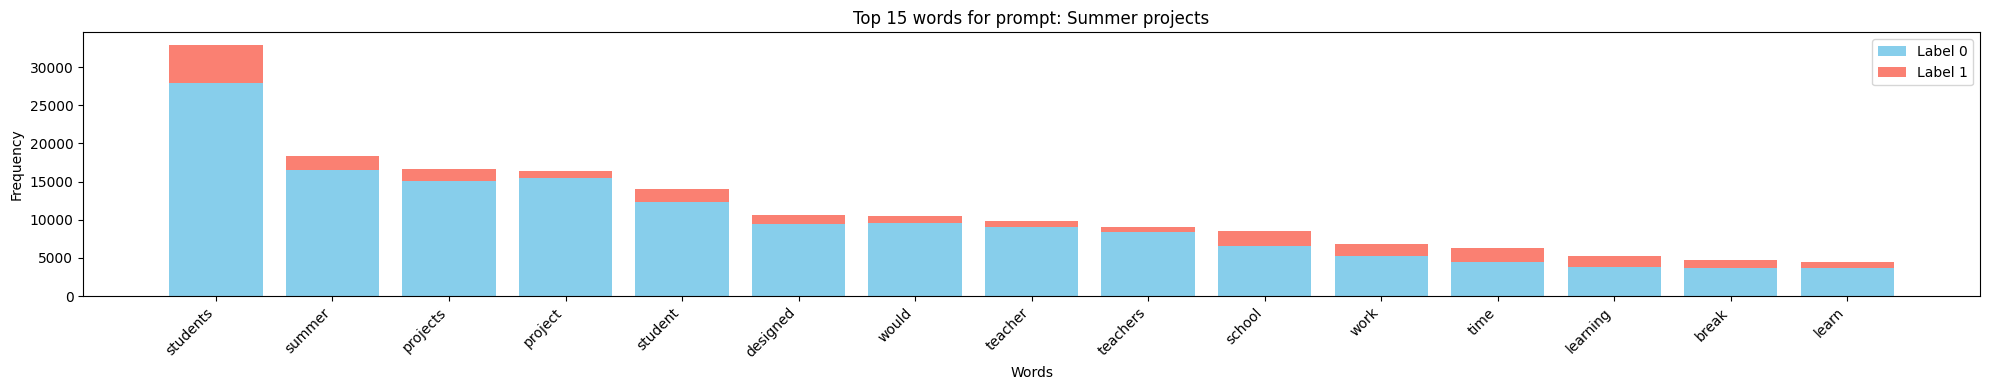

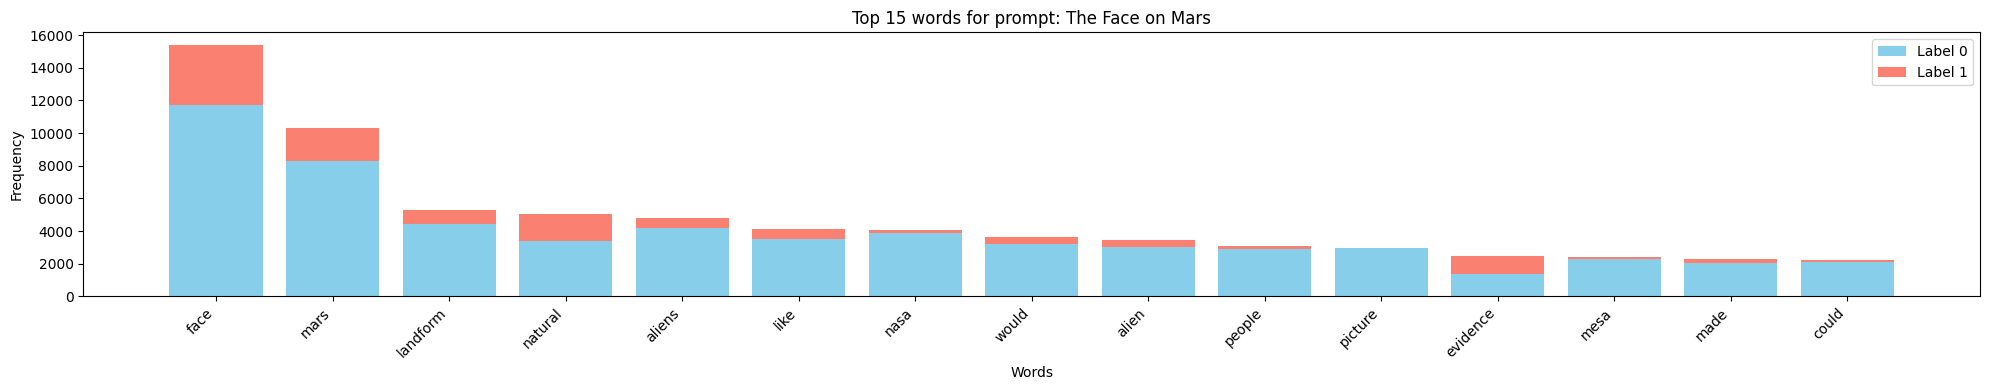

In [ ]:
def plot_top_words(data_pd, n = 15):
    grouped = data_pd.groupby(["prompt_name", "label"])["filtered_words"].apply(lambda x: [word for sublist in x for word in sublist])

    word_counts = {}

    for (prompt, label), words in grouped.items():
        if prompt not in word_counts:
            word_counts[prompt] = {"label_0": Counter(), "label_1": Counter()}

        if label == 0:
            word_counts[prompt]["label_0"].update(words)
        else:
            word_counts[prompt]["label_1"].update(words)

    for prompt, counts in word_counts.items():
        top_words = counts["label_0"] + counts["label_1"]
        top_words = top_words.most_common(n)
        words = [word[0] for word in top_words]
        frequencies_0 = [counts["label_0"][word] for word in words]
        frequencies_1 = [counts["label_1"][word] for word in words]

        plt.figure(figsize = (20, 4))
        plt.bar(words, frequencies_0, label = "Label 0", color = "skyblue")
        plt.bar(words, frequencies_1, bottom = frequencies_0, label = "Label 1", color = "salmon")
        plt.title(f"Top {n} words for prompt: {prompt}")
        plt.xlabel("Words")
        plt.ylabel("Frequency")
        plt.xticks(rotation = 45, ha = "right")
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_top_words(data_pd, n = 15)

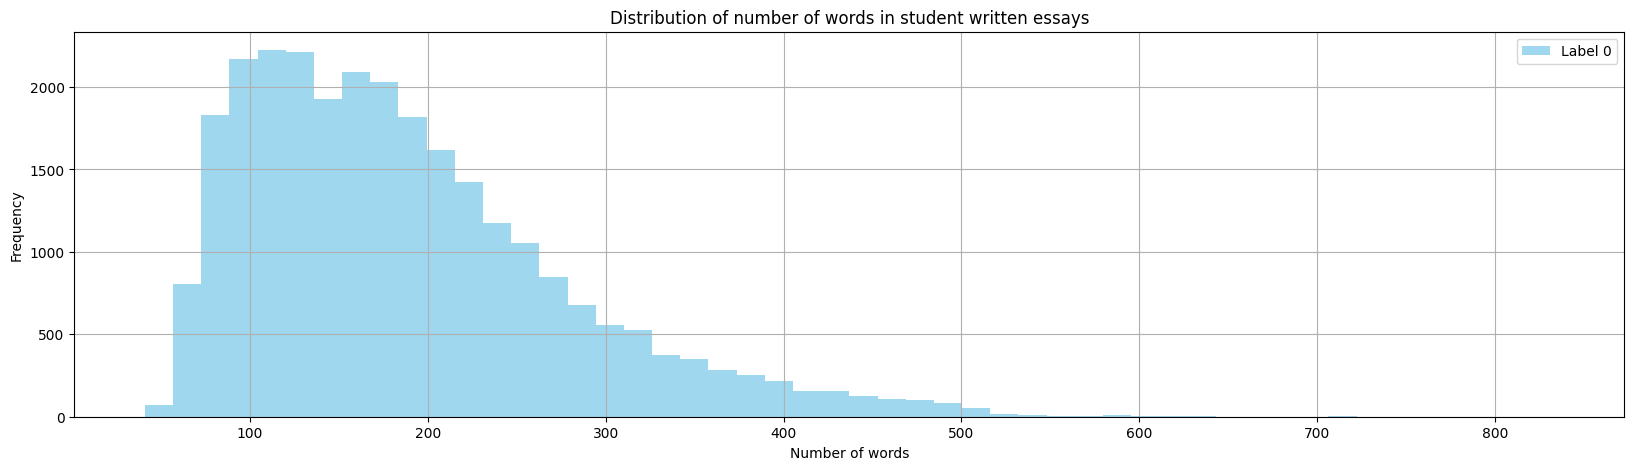

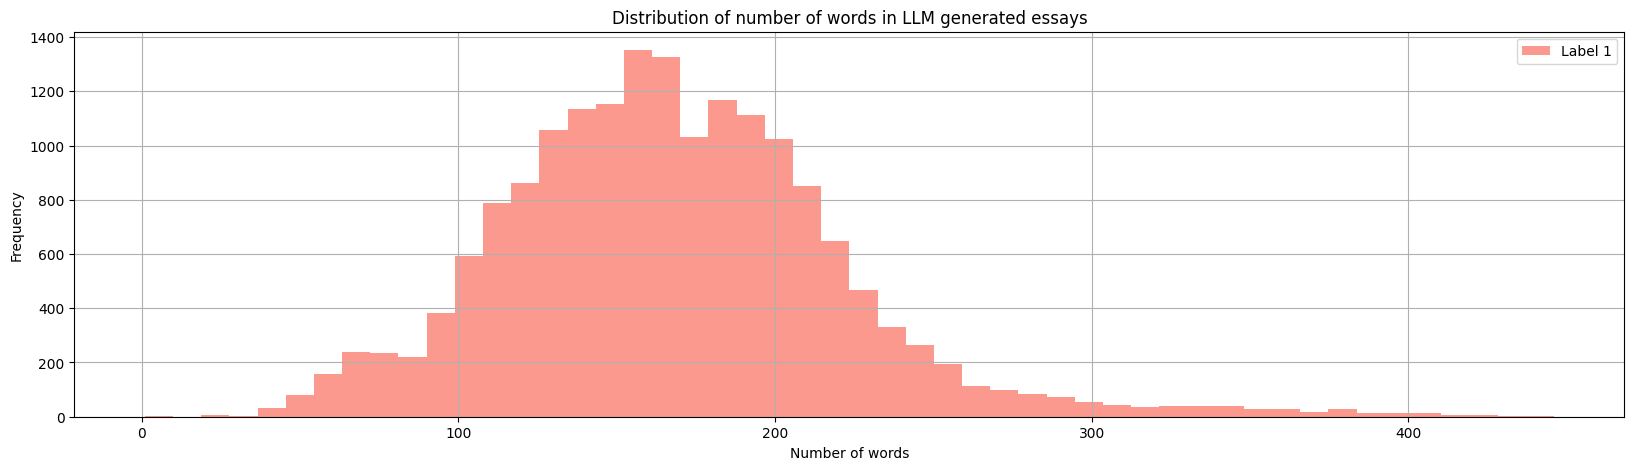

In [ ]:
def plot_word_distribution(data_pd):
    label_0_words = data_pd[data_pd["label"] == 0]["filtered_words"].apply(len)
    label_1_words = data_pd[data_pd["label"] == 1]["filtered_words"].apply(len)

    plt.figure(figsize = (20, 5))
    plt.hist(label_0_words, bins = 50, color = "skyblue", alpha = 0.8, label = "Label 0")
    plt.title("Distribution of number of words in student written essays")
    plt.xlabel("Number of words")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize = (20, 5))
    plt.hist(label_1_words, bins = 50, color = "salmon", alpha = 0.8, label = "Label 1")
    plt.title("Distribution of number of words in LLM generated essays")
    plt.xlabel("Number of words")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_word_distribution(data_pd)

### Classification - deep learning approach

Some words about text classification from [John Snow Labs](https://www.johnsnowlabs.com/mastering-text-classification-with-spark-nlp/). It is a machine learning technique and a fundamental area in NLP and information retrieval, and it is used in many applications such as sentiment analysis, spam filtering, topic categorization, and document organization.

Text classification in deep learning refers to the use of deep neural networks for the task of categorizing text documents into one or more predefined categories. The input is typically represented as a sequence of sentence embeddings to represent sentences as numerical vectors, which can then be used as input to a deep learning model. This allows the model to better understand the context of the text and make more accurate predictions.

The parameters of the deep neural network are trained on a labeled training dataset, typically using a supervised learning approach, where the objective is to minimize the difference between the predicted class labels and the true class labels. After training, the deep neural network can be used to classify new, unseen text documents.

**ClassifierDLApproach** is an annotator in Spark NLP and it provides the ability to train models for multi-class text classification, using a deep learning model (DNNs) built inside TensorFlow, which supports up to 100 classes. It is possible to train a text classifier model with Bert, Elmo, Glove and Universal Sentence Encoders (USE) in using the ClassifierDLApproach annotator.

For model training, we need training and test datasets. For now I will use 30% of my data, so it won't take that much time.

In [13]:
selected_data = cleaned_data.select("text", "prompt_name", "label")
sampled_data = selected_data.sample(fraction = 0.3, seed = 101)
sampled_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 8098|
|    1| 5215|
+-----+-----+



In [ ]:
sampled_data.groupBy("prompt_name").count().show()

+--------------------+-----+
|         prompt_name|count|
+--------------------+-----+
|  Phones and driving|  473|
|Does the electora...| 1268|
|"A Cowboy Who Rod...|  545|
|     Exploring Venus|  632|
|Mandatory extracu...|  910|
|     Driverless cars|  692|
|     Car-free cities| 1405|
|   Distance learning| 1648|
|Cell phones at sc...|  611|
|Grades for extrac...|  600|
|     Summer projects|  826|
|   Community service|  665|
|    The Face on Mars|  565|
|Facial action cod...|  920|
|Seeking multiple ...| 1553|
+--------------------+-----+



In [14]:
train_data, test_data = sampled_data.randomSplit([0.7, 0.3], seed = 42)

print(f"Train data count: {train_data.count()}")
print(f"Test data count: {test_data.count()}")

Train data count: 9446
Test data count: 3867


In [ ]:
train_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 5770|
|    1| 3676|
+-----+-----+



In [ ]:
test_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 2328|
|    1| 1539|
+-----+-----+



Code below transforms raw texts to `document` annotation, encodes text into high dimensional vectors with USE (Universal Sentence Encoder) and performs model training using ClassifierDLApproach annotator. More information about this classifier and its parameters are [here](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/5.Text_Classification_with_ClassifierDL.ipynb).

In [ ]:
document = DocumentAssembler()\
                  .setInputCol("text")\
                  .setOutputCol("document")

use = UniversalSentenceEncoder.pretrained("tfhub_use_lg", "en")\
                  .setInputCols("document")\
                  .setOutputCol("sentence_embeddings")

classsifierdl = ClassifierDLApproach()\
                  .setInputCols(["sentence_embeddings"])\
                  .setOutputCol("class")\
                  .setLabelColumn("label")\
                  .setMaxEpochs(5)\
                  .setLr(0.001)\
                  .setBatchSize(16)\
                  .setEnableOutputLogs(True)

tfhub_use_lg download started this may take some time.
Approximate size to download 753.3 MB
[OK!]


In [ ]:
use_clf_pipeline = Pipeline(stages = [document,
                                      use,
                                      classsifierdl])

pipelineModel = use_clf_pipeline.fit(train_data)

In [ ]:
preds = pipelineModel.transform(test_data)
preds = preds.withColumn("predicted_class", col("class.result").getItem(0).cast("int"))
preds_df = preds.select("label", "text", "predicted_class").toPandas()
print(classification_report(preds_df["label"], preds_df["predicted_class"]))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      2328
           1       0.93      0.90      0.92      1539

    accuracy                           0.93      3867
   macro avg       0.93      0.93      0.93      3867
weighted avg       0.93      0.93      0.93      3867



### Classification - logistic regression

Logistic regression is a popular method to predict a categorical response. It is a special case of Generalized Linear models that predicts the probability of the outcomes. In *spark.ml* logistic regression can be used to predict a binary outcome by using binomial logistic regression, or it can be used to predict a multiclass outcome by using multinomial logistic regression.

In [15]:
selected_data = cleaned_data.select("filtered_words", "label")
sampled_data = selected_data.sample(fraction = 0.3, seed = 101)
train_data, test_data = sampled_data.randomSplit([0.7, 0.3], seed = 42)

In [ ]:
label_indexer = StringIndexer(inputCol = "label", outputCol = "indexed_label").fit(data)
vectorizer = CountVectorizer(inputCol = "filtered_words", outputCol = "raw_features")
idf = IDF(inputCol = "raw_features", outputCol = "features")
lr = LogisticRegression(featuresCol = "features", labelCol = "indexed_label")

In [ ]:
pipeline = Pipeline(stages = [label_indexer, vectorizer, idf, lr])
model = pipeline.fit(train_data)

In [ ]:
predictions = model.transform(test_data)
preds_df = predictions.select("label", "prediction").toPandas()
print(classification_report(preds_df["label"], preds_df["prediction"]))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2324
           1       0.96      0.98      0.97      1543

    accuracy                           0.97      3867
   macro avg       0.97      0.97      0.97      3867
weighted avg       0.97      0.97      0.97      3867



We can se here a little bit better results, but the number of epochs used in the training of a DL classificator could be higher. Considering that, there is still room for improvement of model.

### Clustering - LDA

Latent Dirichlet Allocation (LDA), a topic model designed for text documents. It is a generative probabilistic model of a corpus. The basic idea is
that documents are represented as random mixtures over latent topics, where each topic is characterized by a distribution over words.

First of all I'll use TF-IDF, so I don't have to upload list of stopwords with frequent words from specific topics (like *car* or *cars* in *Car-free cities*).

In [11]:
hashingTF = HashingTF(inputCol = "filtered_words", outputCol = "rawFeatures", numFeatures = 10000)
idf = IDF(inputCol = "rawFeatures", outputCol = "features")

Number of topics will be 15, same as number of different prompts used for writing or generating essays.

In [16]:
lda = LDA(k = 15, maxIter = 10)

pipeline = Pipeline(stages = [hashingTF, idf, lda])

model = pipeline.fit(train_data)

In [18]:
lda_model = model.stages[-1]
topics = lda_model.describeTopics()
print("The topics described by their top-weighted terms:")
topics.show()

The topics described by their top-weighted terms:
+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[5225, 8057, 9214...|[0.02241724769506...|
|    1|[3674, 9690, 3978...|[0.02536458663228...|
|    2|[4867, 3030, 6403...|[0.01674289929493...|
|    3|[2908, 9663, 9481...|[0.01834937252774...|
|    4|[9849, 4046, 8367...|[0.00985624133263...|
|    5|[4034, 2081, 6187...|[0.02231678380060...|
|    6|[3330, 7752, 9826...|[0.00830779528059...|
|    7|[1523, 9343, 1450...|[0.01330221253753...|
|    8|[1523, 5307, 1807...|[0.01333786866145...|
|    9|[1621, 3210, 1626...|[0.01653141319944...|
|   10|[9107, 6140, 7360...|[0.01430660678275...|
|   11|[2252, 8174, 4312...|[0.04075061283174...|
|   12|[1523, 9259, 6328...|[0.00846348847551...|
|   13|[3132, 3370, 3012...|[0.01527168377133...|
|   14|[1841, 573, 9350,...|[0.01476983335601...|
+-----+--------------------+--------------------+


To print more human-friendly results we can use original data used for training - extract unique words and collect them as a list and then convert term indices to actual words.

In [22]:
original_data = train_data.select("filtered_words")
vocab = original_data.select("filtered_words").rdd.flatMap(lambda x: x[0]).distinct().collect()
topics_mapped = topics.rdd.map(lambda row: (row["topic"], [vocab[idx] for idx in row["termIndices"]])).toDF(["topic", "terms"])
topics_mapped.show(truncate = False)

+-----+-----------------------------------------------------------------------------------------------------------+
|topic|terms                                                                                                      |
+-----+-----------------------------------------------------------------------------------------------------------+
|0    |[respresentatives, advangerous, crutches, grades, sugar, acciddents, hemorrhage, antilock, banana, knolege]|
|1    |[hoe, espeically, rearview, substantial, traffic, pe, coding, schoosl, countries, solo]                    |
|2    |[lovely, acount, average's, hiatus, produced, happyn, eight, diffrance, ton, maturing]                     |
|3    |[facd, iowa, lectern, differnet, magacines, degrees, truck, goingto, inn, almighty]                        |
|4    |[buisnessman, shake, expensise, apocolypse, folks, alol, science, truths, specialized, lectern]            |
|5    |[tips, individually, commuity, probably, shipe, spe, ihs, evidanc

In [ ]:
transformed = model.transform(train_data)
transformed.select("filtered_words", "topicDistribution").show()

+--------------------+--------------------+
|      filtered_words|   topicDistribution|
+--------------------+--------------------+
|[''hello, folks, ...|[3.25253123897884...|
|[''unmasking, fac...|[6.54348035702146...|
|['making, mona, l...|[7.17474192877847...|
|[abilitiy, read, ...|[2.93196688482729...|
|[able, car, drive...|[2.90335190127916...|
|[able, go, venus,...|[3.48087665369746...|
|[able, text, driv...|[1.86554975281559...|
|[able, used, clas...|[5.36368907620868...|
|[aboard, enjoy, a...|[3.03672000389451...|
|[abraham, lincoln...|[4.87978287937767...|
|[absolutely, new,...|[6.40264834218171...|
|[according, artic...|[2.64519130772970...|
|[according, artic...|[4.40961976395358...|
|[according, natio...|[2.62187805447358...|
|[according, techn...|[5.51278127697920...|
|[according, text,...|[3.89059135700097...|
|[accurate, way, r...|[6.26775129454322...|
|[across, globe, r...|[2.20420529587967...|
|[adavntages, limi...|[2.01054428396138...|
|[advanced, techno...|[3.1659925

### Spelling & grammar analysis

In next step let's check if f.e. student written essays have some spelling or grammar mistakes more frequent than LLM generated essays (or on the contrary? based on the above small analyses).

To check that I will use Google's **T5**, which is text-to-text transformer based model. It can be used for 18 different tasks ([paper](https://arxiv.org/abs/1910.10683)), f.e. checking the grammar in a sentence. I'll use the prefix `cola sentence:` in the model.

In [ ]:
#MODEL_NAME = "t5_base"
MODEL_NAME = "t5_small"
task_prefix = "cola sentence:"

In [ ]:
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("outputtext")

t5 = T5Transformer()\
    .pretrained(MODEL_NAME)\
    .setTask(task_prefix)\
    .setMaxOutputLength(500)\
    .setInputCols(["outputtext"])\
    .setOutputCol("T5")

pipeline = Pipeline(
    stages = [document_assembler,
              t5]
)

t5_small download started this may take some time.
Approximate size to download 241.9 MB
[OK!]


In [ ]:
pipeline_model = pipeline.fit(sampled_data)
T5model = LightPipeline(pipeline_model)
result = pipeline_model.transform(sampled_data)

In [ ]:
result_label = result.withColumn("result_label", expr("CASE WHEN array_contains(T5.result, 'acceptable') THEN 0 ELSE 1 END").cast("int"))
result_label = result_label.select("label", "result_label")
summary_results = result_label.groupBy("result_label", "label").count()
#summary_results.show()